In [1]:
import imageio as io
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import torch

from PIL import Image
from pose_approximator import PoseApproximator

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Used device: {DEVICE}")

/home/filip/.conda/envs/state_approx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Used device: cuda


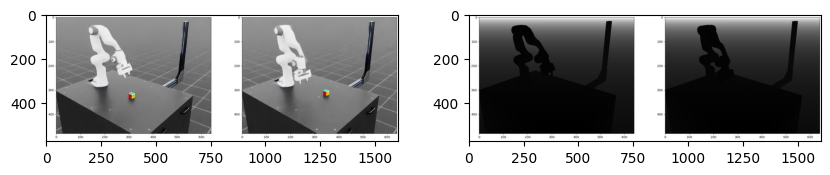

RGB (np.ndarray): 118.27933702256945+-46.03725854787472, [0, 255]
Depth (np.ndarray): 6.739387512207031+-7.119633674621582, [1.3588919639587402, 36.528167724609375]


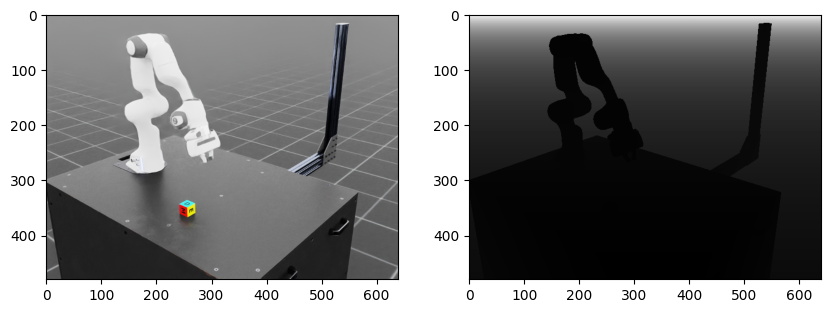

['../data/query_img1.jpg', '../data/query_img2.jpg', '../data/query_img3.jpg', '../data/480x640/query_img.jpg']


In [2]:
root = "../data/"

# Images inputs:
img_path = "../data/480x640/rgb.jpg"
img_pil = Image.open(img_path)
img = np.asarray(img_pil)
#print("RGB: ", type(img))
#print("RGB: ", img.shape)
#print(f"RGB: {img.mean()}+-{img.std()}, [{img.min()}, {img.max()}]")

depth_path = "../data/480x640/depth.jpg"
depth_pil = Image.open(depth_path)
depth = np.asarray(depth_pil)
#print("Depth: ", type(depth))
#print("Depth: ", depth.shape)
#print(f"Depth: {depth.mean()}+-{depth.std()}, [{depth.min()}, {depth.max()}]")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img)
axes[1].imshow(depth)
plt.show()

# np.array inputs:
RGB_INPUT_PATH = "../data/480x640/rgb.npy"
DEPTH_INPUT_PATH = "../data/480x640/depth.npy"
rgb_np = np.load(RGB_INPUT_PATH)[0]
depth_np = np.load(DEPTH_INPUT_PATH)[0]
print(f"RGB (np.ndarray): {rgb_np.mean()}+-{rgb_np.std()}, [{rgb_np.min()}, {rgb_np.max()}]")
print(f"Depth (np.ndarray): {depth_np.mean()}+-{depth_np.std()}, [{depth_np.min()}, {depth_np.max()}]")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(rgb_np)
axes[1].imshow(depth_np, cmap="gray")
plt.show()

query_img_paths = [
    os.path.join(root, "query_img1.jpg"),
    os.path.join(root, "query_img2.jpg"),
    os.path.join(root, "query_img3.jpg"),
    os.path.join(root, "480x640/query_img.jpg"),
]

print(query_img_paths)

query_imgs_pil = [ Image.open(img_path) for img_path in query_img_paths ]
query_imgs = [ np.asarray(img) for img in query_imgs_pil ]

K = torch.tensor([
    [293.1997,   0.0000, 128.0000],
    [  0.0000, 293.1997, 128.0000],
    [  0.0000,   0.0000,   1.0000]
], dtype=torch.float32)

/home/filip/.conda/envs/state_approx/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/filip/.conda/envs/state_approx/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed dur

Detected boxes:  [[256.69763  352.72827   32.460632  32.443016]]


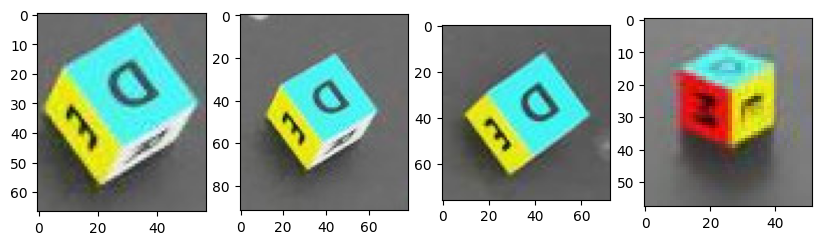

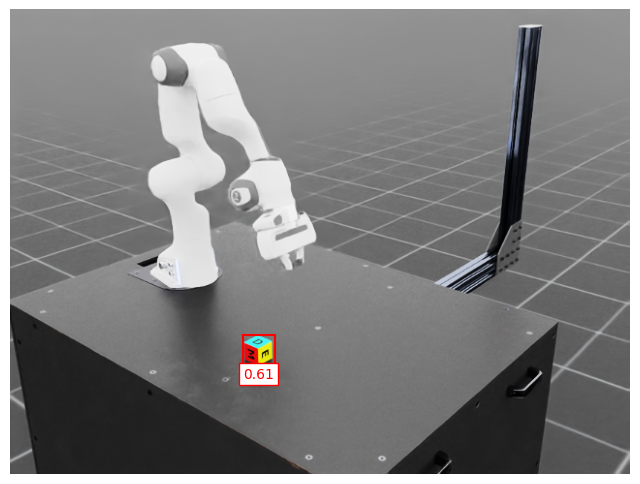

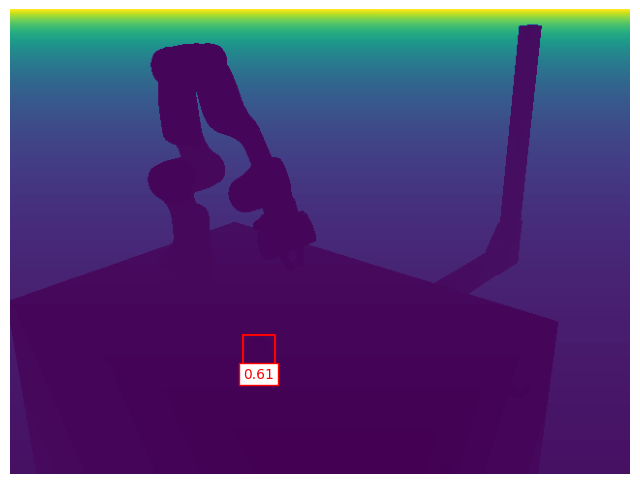

In [3]:
QUERY_IMG = query_imgs
fig, axes = plt.subplots(1, len(QUERY_IMG), figsize=(10, 10))
for i in range(len(QUERY_IMG)):
    axes[i].imshow(QUERY_IMG[i])

SAM_CHECKPOINT = "../segmentation/sam_checkpoint/sam_vit_h_4b8939.pth"

pose_approx = PoseApproximator(device=DEVICE, segm_checkpoint=SAM_CHECKPOINT)
od_tuple, segm_tuple = pose_approx(image=Image.fromarray(rgb_np), query_image=query_imgs, intrinsics=K, od_score_thresh=0.2)

if od_tuple[0] is None:
    raise("No detections")

od_scores = od_tuple[0]
od_lbls = od_tuple[1]
od_boxes = od_tuple[2]

print("Detected boxes: ", od_boxes)
#print(od_boxes.shape)

segm_scores = segm_tuple[0] 
segm_masks = segm_tuple[1]
segm_coords = segm_tuple[2]
segm_lbls = segm_tuple[3]

pose_approx.plot_boxes(img=rgb_np, scores=od_scores, boxes=od_boxes)
pose_approx.plot_boxes(img=depth_np, scores=od_scores, boxes=od_boxes)

scores:  (1,)
masks:  (1, 480, 640)


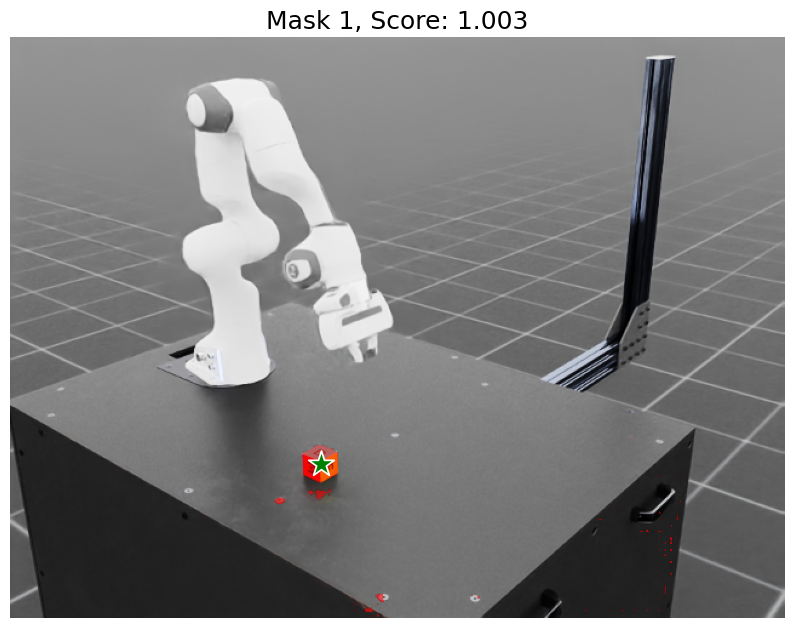

In [4]:
# TODO: Fix this as it shows the bg
print('scores: ', segm_scores.shape)
print('masks: ', segm_masks.shape)
pose_approx.plot_masks(img=rgb_np, scores=segm_scores, masks=segm_masks, input_coords=segm_coords, input_lbls=segm_lbls)

(1, 480, 640)
(1, 4)


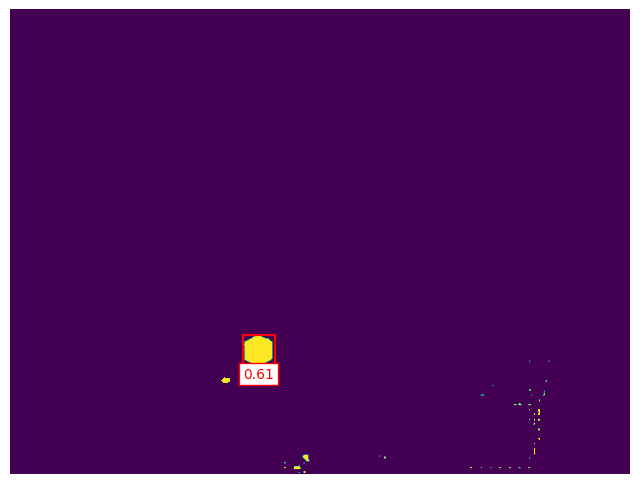

240,336,272,368
(740, 3)
(3, 3)
(740, 3)


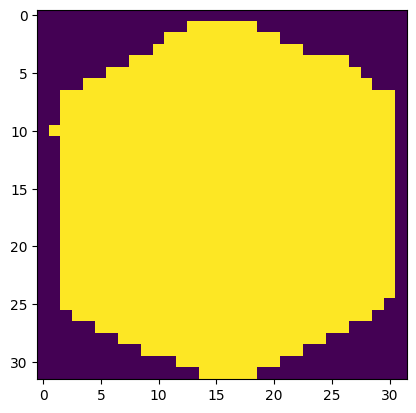

In [5]:
binary_mask = np.zeros_like(depth_np)
print(segm_masks.shape)
print(od_boxes.shape)
binary_mask[segm_masks[0]] = 1
pose_approx.plot_boxes(img=binary_mask, scores=od_scores, boxes=od_boxes)

# extract points from within roi in terms of image coordinates
cx, cy, w, h = od_boxes[0]
x1, y1, x2, y2 = int(cx-w//2), int(cy-h//2), int(cx+w//2), int(cy+h//2)
print(f"{x1},{y1},{x2},{y2}")
crop = binary_mask[y1:y2, x1:x2]
plt.imshow(crop)
indices = np.where(crop == 1)
x_indices, y_indices, _ = indices
x_coords = x_indices + x1
y_coords = y_indices + y1
pnts2d = np.column_stack((x_coords, y_coords))
pnts2d = np.concatenate([pnts2d, np.ones((pnts2d.shape[0], 1))], axis=1)
print(pnts2d.shape)

# deproject to 3d world coordinates: [N, 3] @ [3, 3]
Kinv = np.linalg.pinv(K.cpu().numpy())
print(Kinv.shape)
pnts3d = pnts2d @ Kinv.T
print(pnts3d.shape)

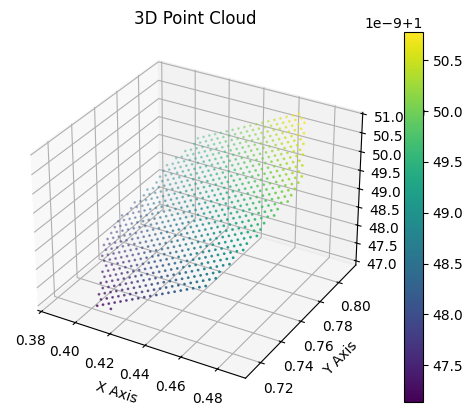

In [6]:
from mpl_toolkits.mplot3d import Axes3D

x = pnts3d[:, 0]
y = pnts3d[:, 1]
z = pnts3d[:, 2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o', s=1)
plt.colorbar(sc)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Point Cloud')
plt.show()

In [14]:
def rotation_matrix_to_quaternion_torch(R):
        # Ensure the rotation matrix is valid
        assert R.shape == (3, 3)

        # Compute quaternion from rotation matrix
        q_w = np.sqrt(1.0 + R[0, 0] + R[1, 1] + R[2, 2]) / 2.0
        q_x = (R[2, 1] - R[1, 2]) / (4.0 * q_w)
        q_y = (R[0, 2] - R[2, 0]) / (4.0 * q_w)
        q_z = (R[1, 0] - R[0, 1]) / (4.0 * q_w)

        return np.array([q_x, q_y, q_z, q_w])

def compute_orientation_from_pointcloud_torch(point_cloud):
        # Compute the centroid of the point cloud
        centroid = np.mean(point_cloud, axis=0)

        # Center the point cloud around the centroid
        centered_point_cloud = point_cloud - centroid

        # Compute the covariance matrix
        covariance_matrix = (centered_point_cloud.T @ centered_point_cloud) / (point_cloud.shape[0] - 1)

        # Perform eigen decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Sort eigenvalues and corresponding eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        # Construct the rotation matrix
        rotation_matrix = sorted_eigenvectors

        # Convert the rotation matrix to a quaternion
        quaternion = rotation_matrix_to_quaternion_torch(rotation_matrix)

        return rotation_matrix, quaternion

rotation_mat, orientation_quat = compute_orientation_from_pointcloud_torch(pnts3d)

print(rotation_mat)
print(orientation_quat)

[[ 3.29831154e-01 -9.44039941e-01 -2.36292347e-08]
 [-9.44039941e-01 -3.29831154e-01 -2.36292347e-08]
 [-1.45132836e-08 -3.01005991e-08  1.00000000e+00]]
[-2.28797282e-09 -3.22297543e-09 -7.85046229e-17  7.07106781e-01]
